In [1]:
import imports
import importlib
importlib.reload(imports)
from imports import *


torch.cuda.is_available(), torch.rand(1).to('cuda:0')


(True, tensor([0.7028], device='cuda:0'))

In [2]:

@dataclass
class DatasetChunk:
    i: int
    x: torch.Tensor
    y: torch.Tensor
    in_memory: bool
    last_read: int
    used: bool

    def __repr__(self):
        return f"DatasetChunk {self.i} in_memory={self.in_memory} last_read={self.last_read} used={self.used}"


class AsyncDatasetReader:
    def __init__(self, max_kept_in_memory):
        global async_dataset_reader_thread

        assert max_kept_in_memory > 1

        self.storage = Storage("cache/storage")
        self.time_counter = 0
                
        self.max_kept_in_memory = max_kept_in_memory
        self.lock = threading.Lock()
        self.first_loaded_event = threading.Event()
        self.chunks = [] # List of DatasetChunk

        self.last_read = -1

        self.device = torch.device("cuda:0")

        async_dataset_reader_thread = threading.Thread(target=self.read_infinitely)
        async_dataset_reader_thread.start()

    def wait_for_first_chunk(self):
        self.params = self.storage.wait_meta_change("params", None)
        self.chunks_count = self.storage.wait_meta_change("chunks_count", 0)

    def find_candidates(self, in_memory):
        stats = list(filter(lambda chunk: chunk.in_memory == in_memory, self.chunks))
        stats.sort(key=lambda chunk: chunk.last_read)
        # print(f"priorites({in_memory}) ", stats)
        return stats
    
    def count_in_memory(self):
        return sum(map(lambda chunk: chunk.in_memory, self.chunks))

    def has_used(self):
        return any(map(lambda chunk: chunk.used and chunk.in_memory, self.chunks))

    def read_next(self):
        self.chunks_count = self.storage.get_meta("chunks_count")
        for i in range(len(self.chunks), self.chunks_count):
            self.chunks.append(DatasetChunk(i, None, None, False, 0, False))
        
      
        if self.count_in_memory() == self.chunks_count:
            print("loaded all into memory")
            # wait till next chunk is written
            self.storage.wait_meta_change("chunks_count", self.chunks_count)
            return
        
        if self.count_in_memory() == self.max_kept_in_memory:
            if self.has_used():
                with self.lock:
                    chunk_to_remove = self.find_candidates(in_memory=True)[-1]
                    assert chunk_to_remove.used
                    x, y = chunk_to_remove.x, chunk_to_remove.y
                    chunk_to_remove.x, chunk_to_remove.y = None, None
                    del x
                    del y
                    chunk_to_remove.in_memory = False
                    chunk_to_remove.used = False
                    print("removed ", chunk_to_remove.i)
            else:
                time.sleep(0.2)
                return

        candidate = self.find_candidates(in_memory=False)[0]
        i = candidate.i
        print(f"reading {i} (last_read={candidate.last_read})")
        candidate.x = self.storage.get("x", i).to(self.device) #, map_location=device)
        candidate.y = self.storage.get("y", i).to(self.device) #, map_location=device)
        with self.lock:
            candidate.in_memory = True
            candidate.used = False
        print(f"read {i}")
        self.first_loaded_event.set()
        
    def read_infinitely(self):
        self.wait_for_first_chunk()
        while True:
            self.read_next()

    def iter_train_batches(self):
        self.first_loaded_event.wait()

        with self.lock:
            candidate = self.find_candidates(in_memory=True)[0]
            print("iter", candidate.i)
            x_train_chunk = candidate.x.to(self.device, non_blocking=True)
            y_train_chunk = candidate.y.to(self.device, non_blocking=True)

            candidate.used = True    
            self.time_counter += 1
            candidate.last_read = self.time_counter

        for x, y in zip(torch.split(x_train_chunk, self.params["batch_size"]),
                        torch.split(y_train_chunk, self.params["batch_size"])):
            yield (x, y)

        del x_train_chunk
        del y_train_chunk

dataset_reader = AsyncDatasetReader(3)


reading 0 (last_read=0)


In [7]:
# for i in range(10):
#     for x, y in dataset_reader.iter_train_batches():
#         pass #print(x.shape)
#     time.sleep(0.2)


In [8]:
# Local
# ->       } client.submit.             Limited by max_parallel and AsyncDataset.parallel_count
# Remote
# ->       } add_done_callback          Limited by max_parallel and AsyncDataset.parallel_count
# Writer
# ->       } send_to_loader             Limited by max_parallel and AsyncDataset.parallel_count
# Loader   
# ->       } read + load to gpu         Limited by read max
# Trainer

from storage import Storage
from stream import Stream
import asyncio
import dataset_builder
import traceback  
import threading
import queue
import time
import concurrent
from collections import defaultdict
import torch.multiprocessing as mptorch
import multiprocessing

params["train_test_split"] = 0.9
params["chunk_size"] = 3000 # 3000 # 300000
params["batch_size"] = 20000
params["max_parallel"] = 3
params["type"] = "lenta"

params["max_last_read_queue_size"] = 1

class AsyncDatasetWriter:
    def __init__(self, client, last_read_queue, chunks_count):
        self.storage = Storage("cache/storage")
        self.storage.clear()
        self.chunks_count = chunks_count

        self.parallel_count = threading.Semaphore(params["max_parallel"])
        self.write_queue = queue.Queue()
        # self.thread_write = threading.Thread(target=asyncio.run, args=(self.write_task(),))
        
        self.last_read_queue_lock = mptorch.Lock()
        self.last_read_queue = last_read_queue
        self.chunks_cnt = 0
        self.device = torch.device('cuda:0')

        self.chunks_iter = None
        self.client = client
        
        self.thread_write = threading.Thread(target=self.write_task)
        self.thread_write.start()
        
        
    def chunk_loaded_callback(self, future):
        print("chunk_loaded_callback")
        self.write_queue.put(future)

    def write(self, future, i):
        # if future.exception() is not None:
        #     future.
            # absprint("ERROR: ", future.exception(), "\n", 
                    # "\n".join(traceback.format_tb(future.traceback())  ))
            # raise future.exception()
        print("getting result started")
        print(future)
        x, y, text_res, is_infected = future.result()
        print("put to last_read_queue")
        if self.last_read_queue.qsize() // 3 + 1 <= params["max_last_read_queue_size"]:
            with self.last_read_queue_lock:
                self.last_read_queue.put(x)
                self.last_read_queue.put(y)
                self.last_read_queue.put(torch.Tensor(i))
        print("writing started")
        print(size_of_tensor(x) / 1024 / 1024, "MB")
        self.storage.store("x", i, x)
        self.storage.store("y", i, y)
        self.storage.store("text_res", i, text_res)
        self.storage.store("is_infected", i, is_infected)
        self.parallel_count.release()
        self.write_queue.task_done()
        print("writing finished")

    def write_task(self):        
        # while True: self.write_queue.get()
        
        try:
            print("write_task started")
            keep_running = True        
            def handle_executor_done_callback(future):
                try:
                    future.result()
                except Exception as e:
                    print("ERROR", "writer thread failed:\n", type(e).__name__, e)
                    print("\n".join(traceback.format_tb(e.__traceback__)))
                    keep_running = False

            with concurrent.futures.ThreadPoolExecutor(params["max_parallel"], "WRITER") as executor:
                chunk_number = 0
                while keep_running:
                    future = executor.submit(self.write, self.write_queue.get(), chunk_number)
                    future.add_done_callback(handle_executor_done_callback)
                    chunk_number += 1
                    self.chunks_count.value += 1
        except Exception as e:
            print("ERROR", "writer thread failed:\n", type(e).__name__, e)
            print("\n".join(traceback.format_tb(e.__traceback__)))
    
    def start_loading_dataset(self, stream):
        # with concurrent.futures.ThreadPoolExecutor(max_workers=params["max_parallel"]) as executor:
        for chunk in stream.group(params["chunk_size"]):
            if not self.thread_write.is_alive(): return
            self.parallel_count.acquire()

            # print("submit")
            # def task():
            #     res = self.client.submit(dataset_builder.create_dataset, (chunk, params, False))
            #     print(self.client.asynchronous, res)
            #     return res

            # future = executor.submit(task)
            # future = client_submit_stub(create_dataset_stub)
            # future = client.submit(create_dataset_stub)
            print("submit")
            future =  self.client.submit(dataset_builder.create_dataset, chunk, params, False)
            # future  = self.client.submit(create_dataset_stub)
            future.add_done_callback(self.chunk_loaded_callback)
            future = None
        
        
def create_and_write_dataset(last_read_queue, chunks_count):
    def internal(last_read_queue, chunks_count):
        print("started")
        from dataset_lib import get_lenta_records
        from dask.distributed import Client
        client = Client("tcp://0.0.0.0:8786")
        load(client)
        stream = Stream(get_lenta_records()).limit(3000).map(lambda record: record.text)
        writer = AsyncDatasetWriter(client, last_read_queue, chunks_count)
        writer.start_loading_dataset(stream)
    
    # proc = mptorch.Process(target=internal, args=(last_read_queue, chunks_count), name="CreateAndWriteDatasetProc")
    proc = multiprocessing.Process(target=internal, args=(last_read_queue, chunks_count), name="CreateAndWriteDatasetProc")
    proc.start()
    return proc
    # internal(last_read_queue, chunks_count)
                           

def stop_write_process():
    for process in mptorch.active_children():
        if "CreateAndWriteDatasetProc" in process.name:
            process.terminate()
            print(f"Terminating process {process.name}")

stop_write_process()
last_read_queue = mptorch.Queue()
chunks_count = mptorch.Value('i', 0)
write_process = create_and_write_dataset(last_read_queue, chunks_count)           

Terminating process CreateAndWriteDatasetProc
started


/home/misha-sh/micromamba/envs/pytorch-env/lib/python3.10/site-packages/distributed/client.py:1381: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | Client | Scheduler | Workers |
+---------+--------+-----------+---------+
| numpy   | 1.23.5 | 1.23.5    | 1.24.2  |
| pandas  | 2.0.0  | 2.0.0     | None    |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


/home/misha-sh/micromamba/envs/pytorch-env/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
zip_safe flag not set; analyzing archive contents...
write_task started
submit


/home/misha-sh/micromamba/envs/pytorch-env/lib/python3.10/site-packages/distributed/worker.py:3031: UserWarning: Large object of size 7.06 MiB detected in task graph: 
  (['Бои у Сопоцкина и Друскеник закончились отступл ... ze': 1}, False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(
2023-04-13 16:08:11,461 - tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x7f44ec53d030>>, <Task finished name='Task-18' coro=<done_callback() done, defined at /home/misha-sh/micromamba/envs/pytorch-env/lib/python3.10/site-packages/distributed/client.py:626> exception=RuntimeError('cannot schedule new futures after interpreter shutdown')>)
T

In [3]:
import multiprocessing
import traceback
import threading
import sys

def worker():
    print("Worker started")
    # Add some long-running operation here
    while True:
        pass

def main():
    p = multiprocessing.Process(target=worker)
    p.start()

    # Get the list of threads in the child process
    threads = []
    for thread in threading.enumerate():
        threads.append(thread)

    # Print the stack trace for each thread
    for thread in threads:
        print(f"Stack trace for thread {thread.name} ({thread.ident}):")
        traceback.print_stack(sys._current_frames()[thread.ident])

main()

Worker startedStack trace for thread MainThread (140507090126656):
Stack trace for thread IOPub (140507018753600):
Stack trace for thread Heartbeat (140507010360896):
Stack trace for thread Thread-3 (_watch_pipe_fd) (140506985182784):
Stack trace for thread Thread-4 (_watch_pipe_fd) (140506633860672):
Stack trace for thread Control (140506625467968):
Stack trace for thread IPythonHistorySavingThread (140506617075264):
Stack trace for thread Thread-2 (140506608682560):


  File "/home/misha-sh/micromamba/envs/pytorch-env/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/misha-sh/micromamba/envs/pytorch-env/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/misha-sh/micromamba/envs/pytorch-env/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/misha-sh/micromamba/envs/pytorch-env/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/home/misha-sh/micromamba/envs/pytorch-env/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
    self.io_loop.start()
  File "/home/misha-sh/micromamba/envs/pytorch-env/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/home/misha-sh/micromamba/envs/pytorch-env/lib/python3.10/asyncio/base_events.p

Process Process-2:
Traceback (most recent call last):
  File "/home/misha-sh/micromamba/envs/pytorch-env/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/misha-sh/micromamba/envs/pytorch-env/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_15174/3979302309.py", line 9, in worker
    while True:
KeyboardInterrupt


In [11]:
x = last_read_queue.get()
y = last_read_queue.get()
i = last_read_queue.get()

FileNotFoundError: [Errno 2] No such file or directory

In [9]:
stop_write_process()

Terminating process CreateAndWriteDatasetProc


In [6]:
write_process

<Process name='Process-1' pid=7442 parent=7390 stopped exitcode=0>

In [26]:
write_process.terminate()

In [18]:
chunks_count.value

0

In [2]:
 

class AsyncDataset:
    def __init__(self, params):
        self.storage = Storage("cache/storage")
        self.storage.clear()
        self.stopped = False
        
        self.parallel_count = threading.Semaphore(params["max_parallel"])
        self.write_queue = queue.Queue()
        # self.thread_write = threading.Thread(target=asyncio.run, args=(self.write_task(),))
        
        self.last_read = mptorch.Queue()
        self.chunks_cnt = 0
        self.device = torch.device('cuda:0')

        self.chunks_iter = None
        

        self.thread_write = threading.Thread(target=self.write_task)
        self.thread_write.start()

    def iter_chunks(self, device):
        while self.last_read == None or self.chunks_cnt <= 0:
            time.sleep(0.5)

        stats = defaultdict(lambda: int())
        time_counter = 0
        i = -1

        def find_candidates():
            stats_sorted = [(stats[i], i) for i in range(self.chunks_cnt)]
            stats_sorted.sort(key=lambda value: value[0])
            print("priorites ", stats_sorted)
            return [i[1] for i in stats_sorted]

        while True:
            last_i = i
            x, y, i = self.last_read
            if i != last_i and stats[i] == 0:
                stats[i] = time_counter
                time_counter += 1
                yield x.to(device), y.to(device)
                continue
            
            candidates = find_candidates()
            
            i = candidates[0]
            x = self.storage.get("x", i).to(device) #, map_location=device)
            y = self.storage.get("y", i).to(device) #, map_location=device)
            # if len(candidates) >= 2:
            #     self.storage.start_loading_async("x", candidates[1], map_location=device)
            yield x, y
            stats[i] = time_counter
            time_counter += 1

    def iter_train_batches(self):
        if self.chunks_iter == None:
            self.chunks_iter = self.iter_chunks(self.device)

        x_train_chunk, y_train_chunk = next(self.chunks_iter)
        for x, y in zip(torch.split(x_train_chunk, params["batch_size"]),
                        torch.split(y_train_chunk, params["batch_size"])):
            yield (x, y)
        del x_train_chunk
        del y_train_chunk


    def stop(self):
        self.stopped = True
        self.write_queue.put(1)



from dataset_lib import get_lenta_records

dataset = AsyncDataset(params)# 300000
loading_thread = threading.Thread(target=dataset.start_loading_dataset, args=(stream,))
loading_thread.start()

writing finished
getting result started
writing started
2207.7108764648438 MB
writing finished
getting result started
writing started
2294.007568359375 MB


In [22]:
dataset.stop()

writing finished


In [15]:
for x, y in dataset.iter_chunks(torch.device("cpu")):
    print(size_of_tensor(x) / 1024 / 1024)
    time.sleep(1)

2258.4918823242188
priorites  [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)]


KeyboardInterrupt: 

In [3]:
dataset

writing finished
getting result started
writing started
2113.6818237304688 MB


In [21]:
params["batch_size"] = 
for x, y in dataset.iter_train_batches():
    print(size_of_tensor(x) / 1024 /1024, size_of_tensor(y))

44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000
44.3115234375 24000


In [ ]:
1

1

writing started
2475.684814453125 MB
writing finished
getting result started
writing started
2176.2053833007812 MB


In [18]:
dataset = None
import gc
gc.collect()

62

In [23]:
# import pip
# pip.main(['install', "objgraph"])
import objgraph
def run():
    for i in objgraph.by_type('torch.Tensor'):
        print(size_of_tensor(i) / 1024 / 1024)
run()

3.814697265625e-05
0.0011444091796875
0.0011444091796875
2854.6148071289062
1.4744911193847656
1.1665763854980469
2258.4918823242188
1.1665763854980469
2258.4918823242188
2258.4918823242188
1.1665763854980469
1.1665763854980469
2258.4918823242188
2216.4180908203125
1.1448440551757812
0.8419189453125
0.00043487548828125
2285.3446655273438
1.1804466247558594
1.1448440551757812
2216.4180908203125


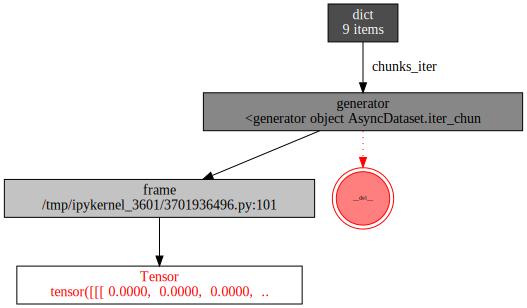

: 

In [24]:
objgraph.show_backrefs(objgraph.by_type('torch.Tensor')[-1])

In [6]:
import gc
gc.collect()

2616

awaiting future


In [13]:
import asyncio
import threading
async def task():
    while True:
        print("test")
        await asyncio.sleep(1)



test
test
test
test
test
test
test
test
test
test
test
test
test
test


In [9]:
future.result()

<coroutine object Future._result at 0x7fd4445d4c80>

In [19]:
dataset.write_queue.qsize()

0

In [22]:
dataset.write_queue._getters

deque([<Future pending cb=[Task.task_wakeup()]>])

In [23]:
dataset.write_queue._putters

deque([])

In [2]:
import dataset_lib
import importlib
importlib.reload(dataset_lib)


params['type'] = 'lenta'
dataset = dataset_lib.Dataset(params, train_test_split=0.9, chunk_size=300000, batch_size=2000)
# dataset.load(50000, 10000) # 50000
dataset.load(50, 10000) # 50000
dataset.to_gpu()


part [0/50]


  0%|          | 0/50 [00:00<?, ?it/s]

Train: 2169 samples (x=48.06 Mb, y=0.02 Mb, 1 chunks, 48.06 Mb per chunk)
Test: 219 samples


In [3]:

# cnt = 686492 # 400000
# input = dataset['input'] = dataset['input'][:cnt]
# output = dataset['output'] = dataset['output'][:cnt]
# dataset['texts_res'] = dataset['texts_res'][:cnt]
# dataset['is_infected'] = dataset['is_infected'][:cnt]

size_of_tensor(dataset.x_train_chunks), size_of_tensor(dataset.y_train_chunks), torch.sum(dataset.y_train_chunks , 0) / len(dataset.y_train_chunks )

AttributeError: 'list' object has no attribute 'nelement'

In [ ]:
a, b = next(dataset.iter_train_batches())

In [4]:
from xformers.factory import xFormerEncoderBlock, xFormerEncoderConfig
N_words = params["INPUT_WORDS_CNT"]
# N_variants = params["VARIANTS_CNT"]
N_features = params["TOTAL_WORD_FEATURES_CNT"]

INTERNAL_EMBEDDING_SIZE = 64

encoder_config = {
    "dim_model": INTERNAL_EMBEDDING_SIZE, #N_variants * N_features,
    "residual_norm_style": "pre",  # Optional, pre/post
    "position_encoding_config": {
        "name": "sine",  #sine
        # "dim_model": VARIANTS_CNT * N_features,
    },
    "multi_head_config": {
        "num_heads": 4,
        "residual_dropout": 0.,
        "attention": {
            "name": "scaled_dot_product", #linformer scaled_dot_product fourier_mix, "linformer" scaled_dot_product,  # whatever attention mechanism
            "dropout": 0., # linformer
            "seq_len": N_words, # linformer, scaled_dot_product
            "to_seq_len": N_words, # scaled_dot_product
        },
    },
    "feedforward_config": {
        "name": "MLP",
        "dropout": 0.,
        "activation": "relu",
        "hidden_layer_multiplier": 1,
    },
}


Either FairScale or torch distributed is not available, MixtureOfExperts will not be exposed. Please install them if you would like to use MoE


0.391 Mb of parameters
[0/400] [1.6 s]	 loss: 1.1574 loss_test: 1.0000  lr: 0.0010  
priorites  [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)]
[1/400] [5.2 s]	 loss: 1.0443 loss_test: 1.0000  lr: 0.0010  
[2/400] [6.8 s]	 loss: 0.9923 loss_test: 1.0000  lr: 0.0010  
priorites  [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 0), (2, 9)]
[3/400] [9.7 s]	 loss: 0.9353 loss_test: 1.0000  lr: 0.0010  
priorites  [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 0), (2, 9), (3, 1)]
[4/400] [12.4 s]	 loss: 0.8676 loss_test: 1.0000  lr: 0.0010  
priorites  [(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 0), (2, 9), (3, 1), (4, 2)]
[5/400] [14.9 s]	 loss: 0.8001 loss_test: 1.0000  lr: 0.0010  
priorites  [(0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 0), (2, 9), (3, 1), (4, 2), (5, 3)]
[6/400] [26.0 s]	 loss: 0.7111 loss_test: 1.0000  lr: 0.0010  
priorites  [(0, 5), (0, 6), (0, 7), (0, 8), (1, 0), (2, 9), (3, 1), (4, 2), (5, 

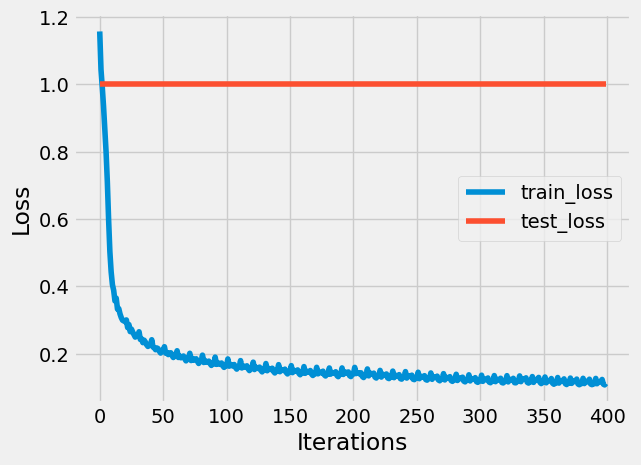

In [21]:
class Model(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        N_words = params['INPUT_WORDS_CNT']
        # N_variants = params['VARIANTS_CNT']
        N_features = params['TOTAL_WORD_FEATURES_CNT']

        # input is (N, N_words, N_features)
        # output is (N, N_words, )

        self.model = nn.Sequential(
            # nn.Flatten(2), 
            # (N, N_words, N_features + )
            # nn.TransformerEncoder(encoder_layer, num_layers=1),encoder = 
            nn.Linear(N_features, INTERNAL_EMBEDDING_SIZE),
            nn.BatchNorm1d(N_words),
            nn.ReLU(),
            
            xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),
            xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),
            xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),
            # xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),

            nn.Flatten(1), # (N, N_words* INTERNAL_EMBEDDING_SIZE)
            # nn.Tanh(),
            nn.Linear(N_words* INTERNAL_EMBEDDING_SIZE, params['TARGET_CLASSES_COUNT']),
            # nn.ReLU(),
            # nn.Linear(100, TARGET_CLASSES_COUNT),
            # nn.Tanh(),
            # nn.Tanhshrink(),
            # nn.Sigmoid(),
            # nn.ReLU(),
        )


    def forward(self, x):
        return self.model(x)

    # buffer_size = 0
    # for buffer in model.buffers():
    #     buffer_size += buffer.nelement() * buffer.element_size()
    # return (param_size + buffer_size) / 1024**2


# asdfadsfasfd

aa = {}
def train_model():
    model = Model()
    print(round(count_parameters(model), 3), "Mb of parameters")
    import importlib
    import trainer_mod
    importlib.reload(trainer_mod)
    Trainer = trainer_mod.Trainer

    # model = torch.compile(model)
    optimizer = torch.optim.Adam(model.parameters(), 
                            lr=1e-3)
                            # betas=(0.5, 0.999))

    trainer = Trainer(model=model, 
                    # enable_chunking=True,
                    # loss=nn.MSELoss(),
                    loss=nn.CrossEntropyLoss(),
                    optimizer=optimizer,
                    scheduler=None,
                    # scheduler=ReduceLROnPlateau(optimizer, factor=0.2, threshold=1e-5, patience=50),
                    additional_losses={
                        # "accurancy": lambda trainer: {"accurancy": 
                        #    float(torch.mean(torch.abs(trainer.model(trainer.x_test) - trainer.y_test)).detach())
                        # },
                    })

    trainer.set_data(dataset)
    try:
        trainer.train(400, trial=None, log=True) # , chunk_size=680000,
    except KeyboardInterrupt:
        print("interrupted")
        # type, val, tb = sys.exc_info()
        # traceback.clear_frames(tb)
        pass
    trainer.plot_history(cutoff=0)
    return trainer
import os
# os.environ["CUDA_HOME"] = "/home/misha-sh/cuda"

trainer = train_model()
# run_proc(train_model)

In [20]:
dataset.chunks_iter = dataset.iter_chunks(dataset.device)

In [ ]:
trainer.model = torch.load("model.v1", map_location=torch.device('cuda:0'))

In [ ]:
Positional embedding должен быть около знака препинания, а не около начала

In [17]:
import __main__

for i in ["_", "__", "___", "____", "_____", "trainer", "model", "optimizer", "Out"] + \
         ["_" + str(j) for j in range(100)]:
    for j in [locals(), globals(), __main__.__dict__]:
        try:
            del j[i]
        except: pass
        for f in range(100):
            try:
                del j["_oh"][f]
            except:
                pass
import sys
try:
    sys.last_traceback.tb_next = None
except: pass

import objgraph
for i in objgraph.by_type('Trainer'):
    i.model = None
    i.x = None
    i.y = None
    i.optimizer = None
    i.x_train = None
    i.y_train = None
    i.x_test = None
    i.y_test = None
    i.dataset = None
    
import gc
# aa.clear()
gc.collect()
torch.cuda.empty_cache() 
1/0


ZeroDivisionError: division by zero

In [ ]:
model = trainer.model.to('cpu:0')

from timeit import default_timer as timer
start = timer()
with torch.no_grad():
    trainer.model(trainer.dataset.x_test)
end = timer()
print(len(trainer.dataset.x_test) / (end - start) / 32, "words per sec")

_ = trainer.model.cuda()

2977.485641907047 words per sec


In [ ]:
torch.save(trainer.model, "model.v1")

<AxesSubplot: >

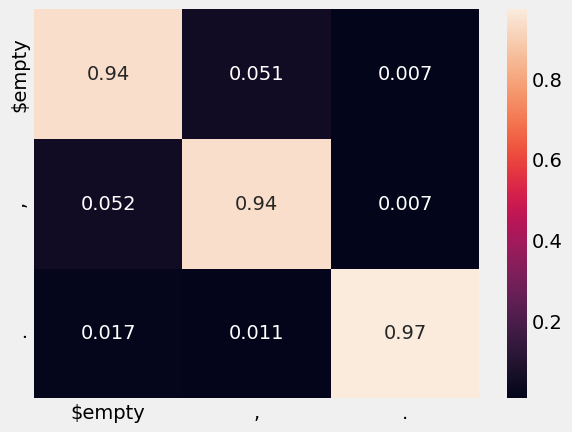

In [ ]:
with torch.no_grad():
    trainer.model.eval()
    y_test_pred = trainer.model(trainer.dataset.x_test.to(trainer.device))
    _, y_pred_tags = torch.max(y_test_pred, dim = 1)
    y_pred = y_pred_tags.cpu().numpy()
    _, y_test_tags = torch.max(trainer.dataset.y_test, dim = 1)
    y_test = y_test_tags.cpu().numpy()
    
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred, normalize="true")).rename(
        columns=params['ID_TO_PUNCTUATION'], index=params['ID_TO_PUNCTUATION'])
sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
morph.parse("Ивана Ивановича")

[Parse(word='ивана ивановича', tag=OpencorporaTag('NOUN,anim,masc,Patr sing,gent'), normal_form='ивана иванович', score=0.5, methods_stack=((FakeDictionary(), 'ивана ивановича', 26, 1), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'овича'))),
 Parse(word='ивана ивановича', tag=OpencorporaTag('NOUN,anim,masc,Patr sing,accs'), normal_form='ивана иванович', score=0.5, methods_stack=((FakeDictionary(), 'ивана ивановича', 26, 3), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'овича')))]

In [ ]:
import shap
import scipy as sp
# https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Using%20custom%20functions%20and%20tokenizers.html
import dataset_builder
importlib.reload(dataset_builder)
trainer.model.eval()

import functools
@functools.lru_cache
def cached_word_features(tokens):
    return dataset_builder.get_word_features(tokens, params)

def inference(tokens_list):
    res = []
    features = torch.stack([
        torch.stack([cached_word_features(token) for token in tokens])
        for tokens in tokens_list])
    with torch.no_grad():
        model_pred = trainer.model(features.to(trainer.device))
        # _, val  = torch.max(model_pred, dim = 1)
        # res.append(val[0].item())
        outputs = model_pred.cpu().numpy()
        scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
        val = sp.special.logit(scores)
    return val
    # trainer.model

masker = shap.maskers.Text(dataset_builder.build_tokens, mask_token="UNDEF", collapse_mask_token=False, output_type="token_ids")

explainer = shap.Explainer(inference, masker, max_evals=100, output_names=["empty", ',', '.'])
# explainer = shap.explainers.Permutation(trainer.model, max_evals=3541)

for i in range(300, 450):
    text = dataset.texts_res[trainer.dataset.test_indices[i]]
    text_input = text.copy()
    del text_input[params['INPUT_WORDS_CNT_LEFT']]

    model_res = inference([text_input])[0]
    if np.argmax(model_res) == np.argmax(dataset.y_test[i].cpu().numpy()): 
        continue
    # if np.argmax(model_res) != 2: continue

    text = " ".join(text)
    text_input = " ".join(text_input)
    print("TARGET:", text)
    print("INPUT:", text_input)
    print("OUTPUT:", model_res)
    # print("OUTPUT:", params["ID_TO_PUNCTUATION"][model_res])
    shap_values = explainer([text_input])
    shap.plots.text(shap_values)
    print("=" * 100)
    print("=" * 100)

TARGET: . По сообщению ВВС , погиб один человек  #$empty#  и около 70 ранены PAD PAD PAD PAD
INPUT: . По сообщению ВВС , погиб один человек и около 70 ранены PAD PAD PAD PAD
OUTPUT: [ -1.2186204   1.2184156 -10.230125 ]


TARGET: силы заняли позиции на высотах южнее населенного пункта  #$empty#  Даргели и у перевала " Волчьи ворота "
INPUT: силы заняли позиции на высотах южнее населенного пункта Даргели и у перевала " Волчьи ворота "
OUTPUT: [-1.7067579 -3.7184432  1.5348765]


TARGET: пресс-центре еще раз подчеркнули , что части Минобороны  #$empty#  непосредственно в боевых действиях участия не принимают а
INPUT: пресс-центре еще раз подчеркнули , что части Минобороны непосредственно в боевых действиях участия не принимают а
OUTPUT: [ -1.9015193   1.9015127 -14.177442 ]


TARGET: требований их абазинский , черкесский и ряд других  #$empty#  проживающих в Карачаево-Черкесии народов " вынуждены будут приступить
INPUT: требований их абазинский , черкесский и ряд других проживающих в Карачаево-Черкесии народов " вынуждены будут приступить
OUTPUT: [ -4.3168287   4.315836  -11.256437 ]


TARGET: черкесский и ряд других проживающих в Карачаево-Черкесии народов  #$empty#  " вынуждены будут приступить к самостоятельному формированию органов
INPUT: черкесский и ряд других проживающих в Карачаево-Черкесии народов " вынуждены будут приступить к самостоятельному формированию органов
OUTPUT: [-0.4954317   0.39006644 -3.6600184 ]


In [ ]:
def full_text_inference():
    tokens = [dataset_builder.PAD_TOKEN] * params['INPUT_WORDS_CNT_LEFT'] + \
            dataset_builder.build_tokens(text, False)['input_ids'] + \
            [dataset_builder.PAD_TOKEN] * params['INPUT_WORDS_CNT_RIGHT']
    for pos in 
        for i in range(params["INPUT_WORDS_CNT_RIGHT"] + 1):
        input.append(PAD_TOKEN)
        output.append(NO_PUNCT)
    dataset_builder

In [ ]:
text = 'PAD ' * 8 + 'Мама пришла , кот съел еду'+ ' PAD' * 7
text_input = text.split()
del text_input[params['INPUT_WORDS_CNT_LEFT']]

model_res = inference([text_input])[0]

text = " ".join(text)
text_input = " ".join(text_input)
print("TARGET:", text)
print("INPUT", text_input)
print("OUTPUT:", model_res)
# print("OUTPUT:", params["ID_TO_PUNCTUATION"][model_res])
shap_values = explainer([text_input])
shap.plots.text(shap_values)

TARGET: P A D   P A D   P A D   P A D   P A D   P A D   P A D   P A D   М а м а   п р и ш л а   ,   к о т   с ъ е л   е д у   P A D   P A D   P A D   P A D   P A D   P A D   P A D
INPUT PAD PAD PAD PAD PAD PAD PAD PAD Мама пришла кот съел еду PAD PAD PAD PAD PAD PAD PAD
OUTPUT: [  3.6143982  -3.615273  -10.711602 ]


In [ ]:
# chain[1] asdf
for elem in chain[1]:
    # if "trainer_mod.Trainer" in str(chain[1][elem]) and not isinstance(chain[1][elem], str)
    if chain[2] == chain[1][elem]:
        print(elem)

for elem in chain[2]:
    if "trainer_mod.Trainer" in str(chain[2][elem]) and not isinstance(chain[2][elem], str)
    # if chain[3] == chain[2][elem]:
        print(elem)

import torch.nn as nn
import torch
def ttest():
    model = nn.Linear(100 * 100, 1).to("cuda:0")
    try:
        for i in range(1000000000):
            pass
    except KeyboardInterrupt:
        print("wer")
        pass
    a = torch.rand(100).to('cuda:0')
    return model
model = ttest()

_oh


In [ ]:
inp = nn.Flatten(2)(input[:11])

config = xFormerEncoderConfig(**encoder_config)

encoder = xFormerEncoderBlock(config)

#  Test out with dummy inputs
x = (torch.rand((10, N_words, N_variants * N_features))).abs().to(torch.float32)
y = encoder(x) # (x, x, x)
print(x.shape, y.shape)

# a = nn.TransformerEncoderLayer(d_model=N_variants *N_features,
#                                nhead=4, dim_feedforward=10, batch_first=True)
# inp.shape, a(inp).shape, count_parameters(a)

In [ ]:
aa

{}

In [ ]:
%reset_selective trainer

In [ ]:

objgraph.find_backref_chain(objgraph.by_type('Trainer')[0], objgraph.is_proper_module)[-2]

SyntaxError: cannot delete function call (3434817761.py, line 2)

In [ ]:
# import objgraph
# objgraph.show_backrefs(objgraph.by_type('Trainer'), 10)

In [ ]:
from xformers.factory import xFormerEncoderBlock, xFormerEncoderConfig
N_words = INPUT_WORDS_CNT
N_variants = VARIANTS_CNT
N_features = FEATURES_CNT

INTERNAL_EMBEDDING_SIZE = 4

encoder_config = {
    "dim_model": INTERNAL_EMBEDDING_SIZE, #N_variants * N_features,
    "residual_norm_style": "pre",  # Optional, pre/post
    "position_encoding_config": {
        "name": "sine",  # whatever position encodinhg makes sense
        # "dim_model": VARIANTS_CNT * N_features,
    },
    "multi_head_config": {
        "num_heads": 4,
        "residual_dropout": 0,
        "attention": {
            "name": "scaled_dot_product", #m fourier_mix, "linformer" scaled_dot_product,  # whatever attention mechanism
            "dropout": 0, # linformer
            "seq_len": N_words, # linformer, scaled_dot_product
            "to_seq_len": N_words, # scaled_dot_product
        },
    },
    "feedforward_config": {
        "name": "MLP",
        "dropout": 0,
        "activation": "relu",
        "hidden_layer_multiplier": 1,
    },
}
# print(INTERNAL_EMBEDDING_SIZE,
#         round(count_parameters(nn.Linear(N_variants * N_features, INTERNAL_EMBEDDING_SIZE)), 4),
#         round(count_parameters(xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config))), 4), "x2 ",
#         round(count_parameters(nn.Linear(N_words* INTERNAL_EMBEDDING_SIZE, TARGET_CLASSES_COUNT)), 4),
#         "=",
#         round(count_parameters(Model()), 4))


In [ ]:
y_test, y_pred

(array([0, 2, 2, ..., 2, 0, 0]), array([0, 2, 2, ..., 1, 0, 0]))

In [ ]:
with torch.no_grad():
    model.eval()
    model.to

In [ ]:
y_test.shape, y_pred_list.shape

((167122, 3), (1, 167122))

In [ ]:
trainer.y_train

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0.])

In [ ]:
# scaler = GradScaler()

# for input, target in data:
#     with torch.autocast(device_type='cuda'):
#         output = model(input)
#         loss = loss_fn(output, target)
#     scaler.scale(loss).backward()
#     scaler.step(optimizer)
#     scaler.update()


In [ ]:


# import sys,functools, traceback
# def gpu_mem_restore(func):
#     "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
#     @functools.wraps(func)
#     def wrapper(*args, **kwargs):
#         try:
#             return func(*args, **kwargs)
#         except:
#             type, val, tb = sys.exc_info()
#             traceback.clear_frames(tb)
#             raise type(val).with_traceback(tb) from None
#     return wrapper

# @gpu_mem_restore